In [ ]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf 
import time

In [ ]:
#load data

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
image_size = x_train.shape[1]
input_size = image_size * image_size

x_train = np.reshape(x_train, [-1, input_size])
x_train = x_train.astype('float32') / 255
x_test = np.reshape(x_test, [-1, input_size])
x_test = x_test.astype('float32') / 255

y_train = y_train.astype('int32').reshape(-1,1)
y_test = y_test.astype('int32').reshape(-1,1)

#stack to simplify below 
X = np.vstack((x_train, x_test))
y = np.vstack((y_train, y_test))

#======= one-hot encoding
digits = 10
examples = y.shape[0]
y = y.reshape(1, examples)
Y_new = np.eye(digits)[y.astype('int32')]
Y_new = Y_new.T.reshape(digits, examples)

# ======= number of training set
m = 60000
m_test = X.shape[0] - m
X_train, X_test = X[:m].T, X[m:].T
Y_train, Y_test = Y_new[:, :m], Y_new[:, m:]


# shuffle training set
shuffle_index = np.random.permutation(m)
X_train, Y_train = X_train[:, shuffle_index].T, Y_train[:, shuffle_index].T
X_test = X_test.T
Y_test = Y_test.T
print(Y_train.shape) # N x C
print(X_train.shape) # N x D
print(X_test.shape) # N x D
print(Y_test.shape) # N x C

11493376/11490434 [==============================] - 0s 0us/step
(60000, 10)
(60000, 784)
(10000, 784)
(10000, 10)


In [ ]:
class MLP(): # 0 hidden layers
    def __init__(self, sizes, epochs=8, l_rate=0.001):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate

        # we save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    # def sigmoid(self, x, derivative=False):
    #   if derivative:
    #     return (np.exp(-x))/((np.exp(-x)+1)**2)
    #   return 1/(1 + np.exp(-x))

    def softmax(self, x, derivative=False):
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def reLU(self, x, derivative=False):
        if(derivative == True):
          return 1. * (x > 0)
        else:
          return x * (x > 0)

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = { #sizes=[784, 10]
                  #-- 0 layers-
                  # 'W1':np.random.randn(output_layer, input_layer) * np.sqrt(1. / output_layer), #10 x 784
                  # 'b1':np.zeros(output_layer)*np.sqrt(1./output_layer) #10 x 1

                  #-- 1 layers -
                  # 'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1), #128 x 784
                  # 'b1':np.zeros(hidden_1), # 128 x1
                  # 'W2':np.random.randn(output_layer, hidden_1) * np.sqrt(1. / output_layer), #10 x 128
                  # 'b2':np.zeros(output_layer) # 10 x1

                  #-- 2 layers
                  'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1), #128 x 784
                  'b1':np.zeros(hidden_1), # 128 x 1
                  'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2), #128 x 128
                  'b2':np.zeros(hidden_2), # 128 x 1
                  'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer), #10x128
                  'b3':np.random.randn(output_layer) # 10 x 1
        }

        return params
    
    def forward_pass(self, x_train):
      params = self.params

      # input layer activations becomes sample
      params['A0'] = x_train # passed in from fit, (1 image, since sgd) => (784,)

      #0 layer ---------------------------
      # params['Z1'] = np.dot(params['W1'], params['A0']) + params['b1'] # 10 x 1 
      # params['A1'] = self.softmax(params['Z1'])
      #-------------------------

      #1 layer --------------------
      # #input layer to hidden layer 1
      # params['Z1'] = np.dot(params['W1'], params['A0']) + params['b1'] # 128 x 1
      # params['A1'] = self.reLU(params['Z1'])

      # #hidden layer to output layer
      # params['Z2'] = np.dot(params['W2'], params['A1']) + params['b2'] # 10 x 1
      # params['A2'] = self.softmax(params['Z2'])

      # ##2 layers ------------------
      # input layer to hidden layer 1
      params['Z1'] = np.dot(params["W1"], params['A0']) + params['b1'] # 128 x 1
      params['A1'] = self.reLU(params['Z1'])

      # hidden layer 1 to hidden layer 2
      params['Z2'] = np.dot(params["W2"], params['A1']) + params['b2'] #128 x 1
      params['A2'] = self.reLU(params['Z2'])

      # hidden layer 2 to output layer
      params['Z3'] = np.dot(params["W3"], params['A2']) + params['b3'] # 10 x 1
      params['A3'] = self.softmax(params['Z3'])

      return params['A3']

    def backward_pass(self, y_train, output, L2, lambdaa):
      params = self.params
      change_w = {}

      # W update - 0 layer ###########
      # error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z1'], derivative=True)
      # change_w['W1'] = np.outer(error, params['A0'])  
      # change_w['b1'] = error

      # 1 layer ------------
      # W2 update
      # error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z2'], derivative=True)
      # change_w['W2'] = np.outer(error, params['A1']) 
      # change_w['b2'] = error

      # # W1 update
      # error = np.dot(params['W2'].T, error) * self.reLU(params['Z1'], derivative=True)
      # change_w['W1'] = np.outer(error, params['A0'])
      # change_w['b1'] = error

      #2 layers ###############
      # Calculate W3 update
      error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
      change_w['W3'] = np.outer(error, params['A2'])
      change_w['b3'] = error

      # Calculate W2 update
      error = np.dot(params['W3'].T, error) * self.reLU(params['Z2'], derivative=True)
      change_w['W2'] = np.outer(error, params['A1'])
      change_w['b2'] = error

      # Calculate W1 update
      error = np.dot(params['W2'].T, error) * self.reLU(params['Z1'], derivative=True)
      change_w['W1'] = np.outer(error, params['A0'])
      change_w['b1'] = error

      #regularization
      if L2: 
        change_w['W3'] += lambdaa*params['W3']
        change_w['W2'] += lambdaa*params['W2']
        change_w['W1'] += lambdaa*params['W1']
      
      return change_w
  
    def sgd(self, changes_to_w):
      for key, value in changes_to_w.items():
        # print(value.shape)
        # print(value)
        # print(self.params[key].shape)
        self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
      predictions = []

      for i in range(x_val.shape[0]):
          output = self.forward_pass(x_val[i]) #sent (784,)
          pred = np.argmax(output)
          predictions.append(pred == np.argmax(y_val[i])) #sent (10,)
      
      return np.mean(predictions)

    def train(self, x_train, y_train, x_val, y_val):
      num_epochs = [] #for plotting
      num_acc = [] #for plotting
      num_et = [] #for plotting training
      num_at = [] #for plotting training
      start_time = time.time()
      for iteration in range(self.epochs):
        #iterate down the arrays and send 1 image in at a time (sgd, batch = 1)
          for i in range(x_train.shape[0]): #x_train = 60,000 x 784, y_train = 60,000 x 10
              output = self.forward_pass(x_train[i]) # sent (784,)
              changes_to_w = self.backward_pass(y_train[i], output, L2=True, lambdaa=0.0001) # sent (10,)
              self.sgd(changes_to_w)
          #test acc
          accuracy = self.compute_accuracy(x_val, y_val) # x, y = 10,000 x 784, 10,000 x 10
          print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
              iteration+1, time.time() - start_time, accuracy * 100))
          num_epochs.append(iteration)
          num_acc.append(accuracy * 100)
          #training acc
          accuracyt = self.compute_accuracy(x_train, y_train)
          num_et.append(iteration)
          num_at.append(accuracyt * 100)
      plt.plot(num_epochs, num_acc, label = "Test")
      plt.plot(num_et, num_at, label = "Train")
      plt.xlabel("Epochs")
      plt.ylabel("Accuracy")
      plt.title("MLP With 2 Hidden ReLu Layers & L2 regularization")
      plt.grid('On')
      fig = plt.gcf()
      leg = plt.legend()
      #return num_acc[-1]
          


Epoch: 1, Time Spent: 58.14s, Accuracy: 73.27%
Epoch: 2, Time Spent: 116.85s, Accuracy: 85.19%
Epoch: 3, Time Spent: 175.03s, Accuracy: 88.45%
Epoch: 4, Time Spent: 233.68s, Accuracy: 89.62%
Epoch: 5, Time Spent: 292.49s, Accuracy: 90.23%
Epoch: 6, Time Spent: 351.47s, Accuracy: 90.91%
Epoch: 7, Time Spent: 410.83s, Accuracy: 91.35%
Epoch: 8, Time Spent: 469.16s, Accuracy: 91.72%


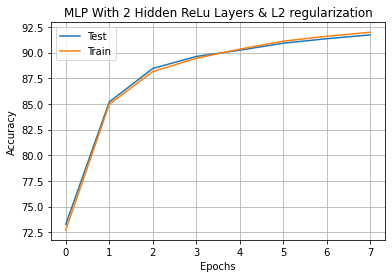

In [ ]:
mlp = MLP(sizes=[784,128,128,10])
mlp.train(X_train, Y_train, X_test, Y_test)

Epoch: 1, Time Spent: 37.67s, Accuracy: 61.98%
Epoch: 2, Time Spent: 75.28s, Accuracy: 78.83%
Epoch: 3, Time Spent: 113.36s, Accuracy: 83.89%
Epoch: 4, Time Spent: 151.44s, Accuracy: 86.55%
Epoch: 5, Time Spent: 189.48s, Accuracy: 87.72%
Epoch: 6, Time Spent: 227.55s, Accuracy: 88.47%
Epoch: 7, Time Spent: 265.92s, Accuracy: 89.18%
Epoch: 8, Time Spent: 303.70s, Accuracy: 89.73%


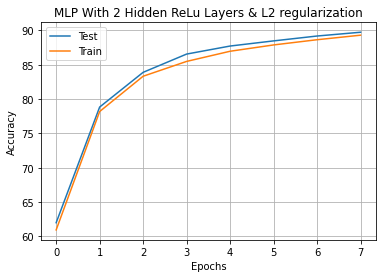

In [ ]:
mlp = MLP(sizes=[784,64,64,10])
mlp.train(X_train, Y_train, X_test, Y_test)

Epoch: 1, Time Spent: 126.77s, Accuracy: 86.14%
Epoch: 2, Time Spent: 254.14s, Accuracy: 89.72%
Epoch: 3, Time Spent: 382.99s, Accuracy: 90.93%
Epoch: 4, Time Spent: 509.18s, Accuracy: 91.57%
Epoch: 5, Time Spent: 634.18s, Accuracy: 92.07%
Epoch: 6, Time Spent: 758.85s, Accuracy: 92.61%
Epoch: 7, Time Spent: 887.94s, Accuracy: 92.98%
Epoch: 8, Time Spent: 1016.61s, Accuracy: 93.26%


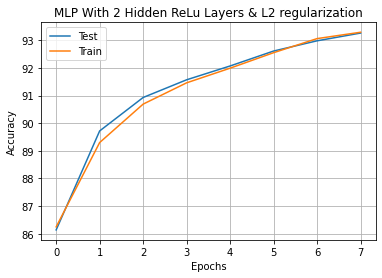

In [ ]:
mlp = MLP(sizes=[784,256,256,10])
mlp.train(X_train, Y_train, X_test, Y_test)

Epoch: 1, Time Spent: 1.01s, Accuracy: 5.83%
Epoch: 2, Time Spent: 2.01s, Accuracy: 5.84%
Epoch: 3, Time Spent: 2.99s, Accuracy: 5.85%
Epoch: 4, Time Spent: 3.94s, Accuracy: 5.84%
Epoch: 5, Time Spent: 4.96s, Accuracy: 5.84%
Epoch: 6, Time Spent: 5.93s, Accuracy: 5.83%
Epoch: 7, Time Spent: 6.91s, Accuracy: 5.86%
Epoch: 8, Time Spent: 7.86s, Accuracy: 5.91%
Epoch: 9, Time Spent: 8.82s, Accuracy: 5.91%
Epoch: 10, Time Spent: 9.86s, Accuracy: 5.90%
Epoch: 11, Time Spent: 10.85s, Accuracy: 5.91%
Epoch: 12, Time Spent: 11.82s, Accuracy: 5.93%
Epoch: 13, Time Spent: 12.63s, Accuracy: 5.95%
Epoch: 14, Time Spent: 13.62s, Accuracy: 5.95%
Epoch: 15, Time Spent: 14.59s, Accuracy: 5.95%
Epoch: 1, Time Spent: 0.93s, Accuracy: 8.66%
Epoch: 2, Time Spent: 1.93s, Accuracy: 8.60%
Epoch: 3, Time Spent: 2.78s, Accuracy: 8.54%
Epoch: 4, Time Spent: 3.76s, Accuracy: 8.50%
Epoch: 5, Time Spent: 4.63s, Accuracy: 8.38%
Epoch: 6, Time Spent: 5.62s, Accuracy: 8.35%
Epoch: 7, Time Spent: 6.56s, Accuracy: 8.32%

No handles with labels found to put in legend.


Epoch: 15, Time Spent: 29.52s, Accuracy: 47.99%


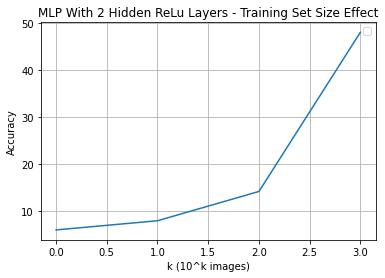

In [ ]:
## training size
accum_acc = [] #accumulate accuracy values

for i in range(4):
  X_train_cut, Y_train_cut = X_train[:10**i,:], Y_train[:10**i,:]
  mlp = MLP(sizes=[784,128,128,10])
  accum_acc.append(dnn.train(X_train_cut, Y_train_cut, X_test, Y_test))

plt.plot(accum_acc)
plt.xlabel("k (10^k images)")
plt.ylabel("Accuracy")
plt.title("MLP With 2 Hidden ReLu Layers - Training Set Size Effect")
plt.grid('On')
fig = plt.gcf()
leg = plt.legend()

accum_acc = []
for i in range(4):
  X_train_cut, Y_train_cut = X_train[:10**i,:], Y_train[:10**i,:]
  mlp = MLP(sizes=[78])